# Week 04 – Other XAI approaches

### !! You need Python 3.9 for this tutorial.

## set up

Before running this notebook you'll need to run the following commands in your terminal:

```
# navigate to week 4 material
cd <./.../04_otherXAI>

git clone https://github.com/tabearoeber/CE-OCL.git

python3.9 -m venv <venv_name>

MacOS: source <venv_name>/bin/activate  
Windows: <venv_name>/Scripts/activate

pip install ipykernel 

python -m ipykernel install --user --name=<venv_name>

pip install -r requirements.txt
```

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import sys
sys.path.insert(1, os.path.dirname(os.getcwd())+'/04_otherXAI/CE-OCL/src')
import embed_mip as em
import ce_helpers

# Load the dataset

We are using the [Statlog (German Credit Data)](http://archive.ics.uci.edu) dataset. The German Credit dataset classifies people described by a set of 20 features as good or bad credit risk.

In [2]:
data = pd.read_csv('../datasets/credit/credit-g_csv.csv')

In [3]:
d = {'target':'class',
    'numerical':list(data.select_dtypes("int64").columns),
    'categorical':list(data.drop('class', axis=1).select_dtypes("object").columns)}

---

# Counterfactual Explanations

In [4]:
# recode class to 0 and 1
recode = {"class": {"bad": 0, "good": 1}}
data = data.replace(recode)

# X and y
X = data.drop(d['target'], axis=1)
y = data[d['target']]

# pre-process data
X, X_train, X_test, y_train, y_test, F_b, data_pip = ce_helpers.prep_data(X, y, d['numerical'],
                                                             one_hot_encoding = True, scaling = True)

## 1. Train a predictive model

We use the code from the repo to train a predictive model. We do this because we'll need the model parameters later on to embed the model in the optimization formulation. When training with the functions written in this repo, the model information is automatically saved for later.

We will try five different models: multilayer perception (mlp), logistic regression (linear), support vector machine (svm), random forest (rf), and a decision tree (cart). 

Then, we will look at the performance of each model and choose one.

In [5]:
alg_list = ['mlp','linear','svm', 'rf', 'cart']

outcome_dict = {'counterfactual_credit':{'task': 'binary', 'X features': X_train.columns, 
                                        'class': d['target'], 'alg_list': alg_list,
                                        'X_train':X_train, 'X_test':X_test,
                                        'y_train':y_train, 
                                          'y_test':y_test}}

## uncomment if models should be trained
ce_helpers.train_models(outcome_dict)

performance = ce_helpers.perf_trained_models(outcome_dict)
performance

Learning a constraint for counterfactual_credit
Training mlp
------------- Initialize grid  ----------------
------------- Running model  ----------------
Algorithm = mlp, metric = None
saving... results/mlp_counterfactual_credit_trained.pkl
------------- Model evaluation  ----------------
-------------------training evaluation-----------------------
Train Score: 1.0
-------------------testing evaluation-----------------------
Test Score: 0.7042857142857142
------------- Save results  ----------------

Training linear
------------- Initialize grid  ----------------
------------- Running model  ----------------
Algorithm = linear, metric = None
saving... results/linear_counterfactual_credit_trained.pkl
------------- Model evaluation  ----------------
-------------------training evaluation-----------------------
Train Score: 0.8219866071428571
-------------------testing evaluation-----------------------
Test Score: 0.8366666666666667
------------- Save results  ----------------

Training

,save_path,seed,cv_folds,task,parameters,best_params,valid_score,train_score,test_score,outcome,alg
0,results/mlp/v1_counterfactual_credit_model.csv,0,5,binary,"{'hidden_layer_sizes': [(10,), (20,), (50,), (...","{'hidden_layer_sizes': (20,)}",0.692132,1.000000,0.704286,counterfactual_credit,mlp
1,results/linear/v1_counterfactual_credit_model.csv,0,5,binary,"{'C': array([0.001, 0.051, 0.101, 0.151, 0.201...","{'C': 0.401, 'penalty': 'l2'}",0.769568,0.821987,0.836667,counterfactual_credit,linear
2,results/svm/v1_counterfactual_credit_model.csv,0,5,binary,"{'C': [0.1, 1, 10, 100]}",{'C': 0.1},0.765960,0.824635,0.828571,counterfactual_credit,svm
3,results/rf/v1_counterfactual_credit_model.csv,0,5,binary,"{'n_estimators': [10, 25], 'max_features': ['s...","{'max_depth': 4, 'max_features': 'sqrt', 'n_es...",0.757701,0.861302,0.826786,counterfactual_credit,rf
4,results/cart/v1_counterfactual_credit_model.csv,0,5,binary,"{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_...","{'max_depth': 9, 'max_features': 0.4, 'min_sam...",0.719289,0.819565,0.711250,counterfactual_credit,cart


Here we can see the performance of each model on the test set. Let's use the svm for this tutorial.

In [6]:
# load models
algorithms = {'counterfactual_credit':'svm'} # specificy model you chose
              
y_pred, y_pred_0, X_test_0, models = ce_helpers.load_model(algorithms, outcome_dict, 'counterfactual_credit') 
clf = models['counterfactual_credit']

## 2. Preparation for optimization

### load the model file

We have prepared this file before. This file contains information about the model we need to embed in the formulation, like which type of model it is, in which .csv file the model parameters are saved, and what the lower and upper bounds are. 

In [7]:
model_master = pd.read_csv('../04_otherXAI/model_master_credit.csv')
model_master['features'] = [[col for col in X_train.columns]]
model_master['model_type'] = algorithms['counterfactual_credit']
model_master['save_path'] = f'results/{algorithms["counterfactual_credit"]}/v1_counterfactual_credit_model.csv'
model_master

,Unnamed: 0,outcome,task,objective,lb,ub,SCM_counterfactuals,features,model_type,save_path
0,0,counterfactual_credit,binary,0,0.5,NaN,NaN,"[checking_status_0<=X<200, checking_status_<0,...",svm,results/svm/v1_counterfactual_credit_model.csv


### choose a factual instance

In [8]:
i = 2
u = X_test_0.iloc[i,:]
# print(u)
print('predicted label: %d' % (clf.predict([u])))
u_df = u.to_frame().T
u_df

predicted label: 0


,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,checking_status_no checking,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,employment_1<=X<4,...,savings_status_<100,savings_status_>=1000,savings_status_no known savings,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
775,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.294118,0.069883,1.0,1.0,0.107143,0.0,0.0


### Criteria that are said to make a good counterfactual

When it comes to counterfactual explanations, there are a lot of criteria that we aim to respect to generate a point that is a plausible and feasible point in practice. The following table comes from [our paper](https://arxiv.org/pdf/2209.10997.pdf), so you can read more about it there and look up the other references if you like. Our approach is called `CE-OCL`, which stands for Counterfactual Explanation using Optimization with Constraint Learning.

<div>
<img src="../img/CEs.png" width="900"/>
</div>

### trust region

<div>
<img src="../img/trust_region.png" width="350"/>
</div>

In [9]:
y_idx_1 = np.where(y_train==1)[0] # get index of y_train instances with value 1
X1 = X_train.iloc[y_idx_1,:].copy().reset_index(drop=True) # get corresponding X_train values

### Questions

#### Q1: Explain what these criteria mean. 

- proximity: find the closest counterfactual according to some distance function 
- sparsity: change as little features as possible
- coherence: when one-hot encoding is used for categorical variables, we must ensure that we get a sensible datapoint in the end that we can map back to the original feature space. So, only one of the dummy variables for a certain categorical feature can take on value 1
- actionability: the counterfactual should be actionable in practice. In practice there may be features that are not changeable (immutable features), like sex. The counterfactual should not propose a change to those features.
- data manifold closeness: ideally we generate a datapoint that is close to the observed data to increase the chance that the datapoint is a sensible one
- causality: if we know the causal relations between some features, we want to account for that in the counterfactual. For example, if x_2 depends on x_1, only proposing a change in x_1 is not sensible. There should also be a change in x_2 then as you may not change one without changing the other.
- diversity: proposing several counterfactual points to increase the likelihood that there is at least one that is attainable for the user

#### Q2: Explain to which of the criteria the trust region belongs and how the trust region works, i.e. how does it attempts to address this criterion?

The trust region addresses the criterion of data manifold. The trust region ensures that the solution lies within the convex hall of the datapoints. As datapoints we could choose the entire dataset, or only those with the desired label. 

## 3. Optimize

The function that runs the actual optimization model requires a lot of parameters: 
- `X_train` -- the training data (`pd.DataFrame`)
- `X1` -- the subset of the data that has 1 as value for the target (`pd.DataFrame`)
- `u` -- the factual instance (`pd.Series`)
- `F_r` -- numerical features (`list`)
- `F_b` -- binary features (`list`)
- `F_int` -- integer features (`list`)
- `F_coh` -- a `dictionary` mapping each categorical feature to its dummy variables. This dictionary is required to ensure that maximum _one_ of the dummies for a categorical variable have value 1. 
- `I` -- immutable features (`list`)
- `L` -- features that can only increase in their value (`list`)
- `Pers_I` -- conditionally mutable features (`list`). These are categorical features that are ordered, like education level, where it is possible to move to a different ('superior') categorical, however not move below the _current_ category.
- `P` -- features that can only take on values greater than 0 (`list`)
- `sp` -- sparsity parameter (`bool`)
- `mu` -- scaling parameter (`int`)
- `tr_region` -- use trust region yes or no? (`bool`)
- `enlarge_tr` -- enlarge the trust region? (`bool`)
- `num_counterfactuals` -- nr of counterfactuals to generate (`int`)
- `model_master` -- dataframe with info about constraints and model (`pd.DataFrame`)

In [10]:
F_r = d['numerical']
F_int = ['num_dependents', 'existing_credits', 'residence_since']

# for coherence
F_coh = {}
for f in d['categorical']:
    F_coh[f] = [i for i in list(X_train.columns.difference(d['numerical'] + [d['target']])) if i.startswith('%s_' % f)]
    
# F_coh

## Part A: validity, proximity

In [11]:
CEs, CEs_, final_model = ce_helpers.opt(X_train, X1, u, 
                                        F_r = d['numerical'], # numerical
                                        F_b = X_train.columns.difference(d['numerical']), # binary
                                        F_int = ['num_dependents', 'existing_credits', 'residence_since'], # integer features 
                                        F_coh = F_coh, 
                                        I = [], # immutable
                                        L = [], # greater or equal to current age
                                        Pers_I = [], # conditionally mutable
                                        P = [], # greater or equal to 0
                                        sp = False, mu = 0, # sparsity
                                        tr_region = False, enlarge_tr = False, # trust region
                                        num_counterfactuals = 1, 
                                        model_master = model_master, 
                                        scaler = data_pip)

Embedding constraints for counterfactual_credit
Academic license - for non-commercial use only - expires 2026-01-27
Using license file /Users/tabearober/gurobi.lic
Changed value of parameter PoolSolutions to 101
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Changed value of parameter PoolSearchMode to 1
   Prev: 0  Min: 0  Max: 2  Default: 0
OBJ: 0.03276461923705413
The optimal solution is: [0.0, 1.0, 0.0, -0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.0, -0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 0.0, -0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.16210973515146634, -0.03894199357871021, 0.9533450411972005, 1.0, 0.14345980303619943, -0.0, -0.0]


### Inspect results

In [12]:
df_a = ce_helpers.visualise_changes(clf, d, F_coh=F_coh, method = 'CE-OCL', CEs=CEs, CEs_ = CEs_, only_changes=True)
df_a

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class,checking_status,credit_history,...,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker
original,24.00,1371.26,4.00,4.0,25.00,1.0,1.0,0.0,<0,existing paid,...,no known savings,1<=X<4,female div/dep/mar,none,real estate,none,rent,skilled,none,yes
sol0,15.02,-333.52,3.86,-,27.04,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-


#### Q3: Explain the table.

The first row shows the original instance, also called _factual_. This is the sample that we got a prediction for (class 0, i.e. bad credit risk) and that we aim to explain. The second row shows the calculated counterfactual. A dash (-) symbolizes no change in the respective features compared to the factual. For all other features we see the value they should take on to flip the model prediction. We also see the model prediction (in column `class`), which changed to 1.

### Evaluation

The authors of the paper [Explaining machine learning classifiers through diverse counterfactual explanations](https://dl.acm.org/doi/abs/10.1145/3351095.3372850) propose some quantitative metrics to evaluate counterfactual explanations along the dimensions validity, proximity (categorical and continuous), sparsity, and diversity (categorical and continuous). The results are averaged over the generated counterfactuals.

- `validity` -- ranges from 0 to 1, with 1 being the best value
- `cat_prox` -- ranges from 0 to 1, with 1 being the best value
- `cont_prox` -- ranges from -inf to 0, with 0 being the best value
- `sparsity` -- ranges from 0 to 1, with 1 being the best value
- `cat_diver` -- ranges from 0 to 1, with 1 being the best value
- `cont_diver` -- ranges from 0 to +inf, the higher the better
- `cont_count_divers` -- sparsity-based diversity -- ranges from 0 to 1, with 1 being the best value

In [13]:
df_orig = ce_helpers.visualise_changes(clf, d, F_coh=F_coh, method='CE-OCL', CEs=CEs, CEs_=CEs_)
CE_perf = ce_helpers.evaluation(df_orig, d).set_index(pd.Index(['Part A']))
CE_perf

,validity,cat_prox,cont_prox,sparsity,cat_diver,cont_diver,cont_count_divers
Part A,1.0,1.0,-1715.94,0.8,None,None,None


#### Q4: Explain why the value for cat_prox is 1. Also explain why there are some None values.

None of the categorical values are changed in the counterfactual. The scores for the diversity measures are None because we only generated 1 counterfactual, so there is no diversity. 

## Part B: validity, proximity, sparsity

In [14]:
CEs, CEs_, final_model = ce_helpers.opt(X_train, X1, u, 
                                        F_r = d['numerical'], # numerical
                                        F_b = X_train.columns.difference(d['numerical']), # binary
                                        F_int = ['num_dependents', 'existing_credits', 'residence_since'], # integer features 
                                        F_coh = F_coh, 
                                        I = [], # immutable
                                        L = [], # greater or equal to current age
                                        Pers_I = [], # conditionally mutable
                                        P = [], # greater or equal to 0
                                        sp = True, mu = 10000, # sparsity
                                        tr_region = False, enlarge_tr = False, # trust region
                                        num_counterfactuals = 1, 
                                        model_master = model_master, 
                                        scaler = data_pip)

Embedding constraints for counterfactual_credit
Changed value of parameter PoolSolutions to 101
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Changed value of parameter PoolSearchMode to 1
   Prev: 0  Min: 0  Max: 2  Default: 0
OBJ: 10000.06160420076
The optimal solution is: [0.0, 1.0, 0.0, -0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.0, -0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 0.0, -0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.04591571160926833, 0.06988320888558519, 1.0, 1.0, 0.10714285714129801, -0.0, -0.0]


### Inspect results

In [15]:
df_b = ce_helpers.visualise_changes(clf, d, F_coh=F_coh, method = 'CE-OCL', CEs=CEs, CEs_ = CEs_, only_changes=True)
df_b

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class,checking_status,credit_history,...,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker
original,24.00,1371.26,4.0,4.0,25.0,1.0,1.0,0.0,<0,existing paid,...,no known savings,1<=X<4,female div/dep/mar,none,real estate,none,rent,skilled,none,yes
sol0,7.12,-,-,-,-,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-


### Evaluation

In [16]:
df_orig = ce_helpers.visualise_changes(clf, d, F_coh=F_coh, method='CE-OCL', CEs=CEs, CEs_=CEs_)
CE_perf = pd.concat([CE_perf, ce_helpers.evaluation(df_orig, d)]).set_index(pd.Index(['Part A', 'Part B']))
CE_perf

,validity,cat_prox,cont_prox,sparsity,cat_diver,cont_diver,cont_count_divers
Part A,1.0,1.0,-1715.94,0.80,None,None,None
Part B,1.0,1.0,-16.88,0.95,None,None,None


#### Q5: How did the results change? Explain in light of the 'criterion' that we added in this part.

We can see that the value for the objective function is larger than before. We added constraints to address sparsity, so changing less features, which may come at a cost of distance to the factual. We see that the score for sparsity went up to 0.95 (compared to 0.8 before). We also see that the proposed counterfactual constitutes a change in only one feature, the `duration`.

## Part C: validity, proximity, sparsity, diversity

In [17]:
CEs, CEs_, final_model = ce_helpers.opt(X_train, X1, u, 
                                        F_r = d['numerical'], # numerical
                                        F_b = X_train.columns.difference(d['numerical']), # binary
                                        F_int = ['num_dependents', 'existing_credits', 'residence_since'], # integer features 
                                        F_coh = F_coh, 
                                        I = [], # immutable
                                        L = [], # greater or equal to current age
                                        Pers_I = [], # conditionally mutable
                                        P = [], # greater or equal to 0
                                        sp = True, mu = 10000, # sparsity
                                        tr_region = False, enlarge_tr = False, # trust region
                                        num_counterfactuals = 3, 
                                        model_master = model_master, 
                                        scaler = data_pip)

Embedding constraints for counterfactual_credit
Changed value of parameter PoolSolutions to 103
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Changed value of parameter PoolSearchMode to 1
   Prev: 0  Min: 0  Max: 2  Default: 0
OBJ: 10000.06160420076
The optimal solution is: [0.0, 1.0, 0.0, -0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.0, -0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 0.0, -0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.04591571160926833, 0.06988320888558519, 1.0, 1.0, 0.10714285714129801, -0.0, -0.0]


### Inspect results

In [18]:
df_c = ce_helpers.visualise_changes(clf, d, F_coh=F_coh, method = 'CE-OCL', CEs=CEs, CEs_ = CEs_, only_changes=True)
df_c

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class,checking_status,credit_history,...,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker
original,24.0,1371.26,4.0,4.0,25.0,1.0,1.0,0.0,<0,existing paid,...,no known savings,1<=X<4,female div/dep/mar,none,real estate,none,rent,skilled,none,yes
sol0,7.12,-,-,-,-,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-
sol1,-,-2873.47,-,-,30.06,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-
sol2,-,-,1.96,-,26.63,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-


### Evaluation

In [19]:
df_orig = ce_helpers.visualise_changes(clf, d, F_coh=F_coh, method='CE-OCL', CEs=CEs, CEs_=CEs_)
CE_perf = pd.concat([CE_perf, ce_helpers.evaluation(df_orig, d)]).set_index(pd.Index(['Part A', 'Part B', 'Part C']))
CE_perf

,validity,cat_prox,cont_prox,sparsity,cat_diver,cont_diver,cont_count_divers
Part A,1.0,1.0,-1715.94,0.80,NaN,NaN,NaN
Part B,1.0,1.0,-16.88,0.95,NaN,NaN,NaN
Part C,1.0,1.0,-1423.45,0.92,0.0,2845.81,0.15


## Part D: validity, proximity, sparsity, diversity, actionability

In [20]:
# features that can only increase (become larger)
L = ['age', 'residence_since']
# L = ['residence_since']

# immutable features
I = ['personal_status_male div/sep', 'personal_status_male mar/wid','personal_status_male single',
     'purpose_domestic appliance', 'purpose_education', 'purpose_furniture/equipment', 'purpose_new car',
     'purpose_other', 'purpose_radio/tv', 'purpose_repairs', 'purpose_retraining', 'purpose_used car',
     'foreign_worker_yes']

employment = ['employment_unemployed', 'employment_<1', 'employment_1<=X<4','employment_4<=X<7', 'employment_>=7']
Pers_I = [employment] # variables that must be considered for person specific immutable features

P = ['duration', 'installment_commitment', 'num_dependents', 'credit_amount', 'existing_credits']

In [21]:
CEs, CEs_, final_model = ce_helpers.opt(X_train, X1, u, 
                                        F_r = d['numerical'], # numerical
                                        F_b = X_train.columns.difference(d['numerical']), # binary
                                        F_int = ['num_dependents', 'existing_credits', 'residence_since'], # integer features 
                                        F_coh = F_coh, 
                                        I = I, # immutable
                                        L = L, # greater or equal to current age
                                        Pers_I = Pers_I, # conditionally mutable
                                        P = P, # greater or equal to 0
                                        sp = True, mu = 10000, # sparsity
                                        tr_region = False, enlarge_tr = False, # trust region
                                        num_counterfactuals = 3, 
                                        model_master = model_master, 
                                        scaler = data_pip)

Embedding constraints for counterfactual_credit
Changed value of parameter PoolSolutions to 103
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Changed value of parameter PoolSearchMode to 1
   Prev: 0  Min: 0  Max: 2  Default: 0
OBJ: 10000.061604200788
The optimal solution is: [0.0, 1.0, 0.0, 0.0, 0.0, -0.0, 0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -0.0, 1.0, 0.0, 1.0, -0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.045915711555859925, 0.06988320888378308, 1.0, 1.0, 0.10714285714129801, -0.0, -0.0]


### Inspect results

In [22]:
df_d = ce_helpers.visualise_changes(clf, d, F_coh=F_coh, method = 'CE-OCL', CEs=CEs, CEs_ = CEs_, only_changes=True)
df_d

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class,checking_status,credit_history,...,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker
original,24.0,1371.26,4.0,4.0,25.0,1.0,1.0,0.0,<0,existing paid,...,no known savings,1<=X<4,female div/dep/mar,none,real estate,none,rent,skilled,none,yes
sol0,7.12,-,-,-,-,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-
sol1,-,-,1.96,-,26.63,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-
sol2,-,-,-,-,75.52,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-


### Evaluation

In [23]:
df_orig = ce_helpers.visualise_changes(clf, d, F_coh=F_coh, method='CE-OCL', CEs=CEs, CEs_=CEs_)
CE_perf = pd.concat([CE_perf, ce_helpers.evaluation(df_orig, d)]).set_index(pd.Index(['Part A', 'Part B', 'Part C', 'Part D']))
CE_perf

,validity,cat_prox,cont_prox,sparsity,cat_diver,cont_diver,cont_count_divers
Part A,1.0,1.0,-1715.94,0.80,NaN,NaN,NaN
Part B,1.0,1.0,-16.88,0.95,NaN,NaN,NaN
Part C,1.0,1.0,-1423.45,0.92,0.0,2845.81,0.15
Part D,1.0,1.0,-23.69,0.93,0.0,46.29,0.12


#### Q6: What is `Pers_I`?

Some features are conditionally (im)mutable. This is especially the case for categorical variables with an order. In this case we have the feature `employment`, which is a categorical variable indicating how long the person has been employed at their job. We don't want that people quit their job to achieve a 'lower level' of this category, and hence we want the counterfacual to not propose a change to a 'lower category'. For every individual, which categories are 'lower' depend on their current category. So, we create a list of ordered values for each of these variables. The constraint added for this will make sure that any counterfactual generated remains in the current category for that feature or a 'higher' one, never a lower one.

## Part E: validity, proximity, sparsity, diversity, actionability, trust region

In [24]:
try: CEs, CEs_, final_model = ce_helpers.opt(X_train, X1, u, 
                                        F_r = d['numerical'], # numerical
                                        F_b = X_train.columns.difference(d['numerical']), # binary
                                        F_int = ['num_dependents', 'existing_credits', 'residence_since'], # integer features 
                                        F_coh = F_coh, 
                                        I = I, # immutable
                                        L = L, # greater or equal to current age
                                        Pers_I = Pers_I, # conditionally mutable
                                        P = P, # greater or equal to 0
                                        sp = True, mu = 10000, # sparsity
                                        tr_region = True, enlarge_tr = False, # trust region
                                        num_counterfactuals = 3, 
                                        model_master = model_master, 
                                        scaler = data_pip)
except:
    print('----TRUST REGION IS BEING ENLARGED----')
    CEs, CEs_, final_model = ce_helpers.opt(X_train, X1, u, 
                                        F_r = d['numerical'], # numerical
                                        F_b = X_train.columns.difference(d['numerical']), # binary
                                        F_int = ['num_dependents', 'existing_credits', 'residence_since'], # integer features 
                                        F_coh = F_coh, 
                                        I = I, # immutable
                                        L = L, # greater or equal to current age
                                        Pers_I = Pers_I, # conditionally mutable
                                        P = P, # greater or equal to 0
                                        sp = True, mu = 10000, # sparsity
                                        tr_region = True, enlarge_tr = True, # trust region
                                        num_counterfactuals = 3, 
                                        model_master = model_master, 
                                        scaler = data_pip)

Generating constraints for the trust region using 560 samples.
The trust region is not being enlarged.
... Trust region defined.
Embedding constraints for counterfactual_credit
Changed value of parameter PoolSolutions to 103
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Changed value of parameter PoolSearchMode to 1
   Prev: 0  Min: 0  Max: 2  Default: 0
OBJ: 80006.00089659344
The optimal solution is: [0.0, 0.0, 0.0, 1.0, 0.0, -0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, -0.0, -0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.2647058823529422, 0.06426702406024631, 1.0, 1.0, 0.10714285714129801, 0.0, 0.0]


### Inspect results

In [25]:
df_e = ce_helpers.visualise_changes(clf, d, F_coh=F_coh, method = 'CE-OCL', CEs=CEs, CEs_ = CEs_, only_changes=True)
df_e

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class,checking_status,credit_history,...,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker
original,24.0,1371.26,4.0,4.0,25.0,1.0,1.0,0.0,<0,existing paid,...,no known savings,1<=X<4,female div/dep/mar,none,real estate,none,rent,skilled,none,yes
sol0,22.0,1283.52,-,-,-,-,-,1.0,no checking,-,...,-,4<=X<7,-,-,life insurance,-,-,-,-,-
sol1,12.0,1893.04,-,-,29.0,-,-,1.0,-,-,...,<100,-,-,guarantor,life insurance,-,own,-,yes,-
sol2,10.0,1363.43,2.0,-,64.0,-,-,1.0,no checking,-,...,<100,-,-,-,car,-,own,-,yes,-


### Evaluation

In [26]:
df_orig = ce_helpers.visualise_changes(clf, d, F_coh=F_coh, method='CE-OCL', CEs=CEs, CEs_=CEs_)
CE_perf = pd.concat([CE_perf, ce_helpers.evaluation(df_orig, d)]).set_index(pd.Index(['Part A', 'Part B', 'Part C', 'Part D', 'Part E']))
CE_perf

,validity,cat_prox,cont_prox,sparsity,cat_diver,cont_diver,cont_count_divers
Part A,1.0,1.00,-1715.94,0.80,NaN,NaN,NaN
Part B,1.0,1.00,-16.88,0.95,NaN,NaN,NaN
Part C,1.0,1.00,-1423.45,0.92,0.00,2845.81,0.15
Part D,1.0,1.00,-23.69,0.93,0.00,46.29,0.12
Part E,1.0,0.67,-230.12,0.63,0.36,441.68,0.42


## 4. Final evaluation

In [27]:
df_complete = pd.concat([df_a, df_b, df_c, df_d, df_e])
df_complete

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class,checking_status,credit_history,...,savings_status,employment,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker
original,24.0,1371.26,4.0,4.0,25.0,1.0,1.0,0.0,<0,existing paid,...,no known savings,1<=X<4,female div/dep/mar,none,real estate,none,rent,skilled,none,yes
sol0,15.02,-333.52,3.86,-,27.04,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-
original,24.0,1371.26,4.0,4.0,25.0,1.0,1.0,0.0,<0,existing paid,...,no known savings,1<=X<4,female div/dep/mar,none,real estate,none,rent,skilled,none,yes
sol0,7.12,-,-,-,-,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-
original,24.0,1371.26,4.0,4.0,25.0,1.0,1.0,0.0,<0,existing paid,...,no known savings,1<=X<4,female div/dep/mar,none,real estate,none,rent,skilled,none,yes
sol0,7.12,-,-,-,-,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-
sol1,-,-2873.47,-,-,30.06,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-
sol2,-,-,1.96,-,26.63,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-
original,24.0,1371.26,4.0,4.0,25.0,1.0,1.0,0.0,<0,existing paid,...,no known savings,1<=X<4,female div/dep/mar,none,real estate,none,rent,skilled,none,yes
sol0,7.12,-,-,-,-,-,-,1.0,-,-,...,-,-,-,-,-,-,-,-,-,-


In [28]:
CE_perf

,validity,cat_prox,cont_prox,sparsity,cat_diver,cont_diver,cont_count_divers
Part A,1.0,1.00,-1715.94,0.80,NaN,NaN,NaN
Part B,1.0,1.00,-16.88,0.95,NaN,NaN,NaN
Part C,1.0,1.00,-1423.45,0.92,0.00,2845.81,0.15
Part D,1.0,1.00,-23.69,0.93,0.00,46.29,0.12
Part E,1.0,0.67,-230.12,0.63,0.36,441.68,0.42


---
---

# Symbolic regression


In this notebook you will use different approaches to symbolic regression: GPLearn for symbolic regression, and other non-symbolic regression methods (DT and RF)



In [29]:
# RUN THIS CELL FIRST. Do not change.

import warnings
warnings.filterwarnings("ignore")
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
import matplotlib.pyplot as plt

First, we create the data used for the methods mentioned above. The code below creates a surfaceplot of all points $(x_1,x_2)$ between -1 and 1 for two features $x_1$ and $x_2$, according to the equation $y_{truth} = x_1^2 - x_2^2 + x_2 - 1$. In the methods below we will try to find an equation that best fits $y_{truth}$. 

1. GPLearn for Symbolic Regression
2. Decision Tree Regression
3. Random Forest Regression

Recall that in case of symbolic regression, the goal is to find an equation. To compare to other non-linear methods, we include Decision Tree (DT) Regression and Random Forest (RF) Regression. However, these methods will not produce an equation, but will simply train a DT or RF that best matches the given data.

### create surface plot

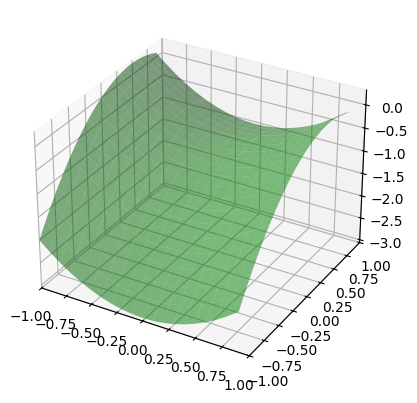

In [30]:
# RUN THIS CELL. Do not change.

# Creating surface plot of y_truth
x1 = np.arange(-1, 1, 1/10.)
x2 = np.arange(-1, 1, 1/10.)
x1, x2 = np.meshgrid(x1, x2)
y_truth = x1**2 - x2**2 + x2 - 1

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x1, x2, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
plt.show()

#### Q1. Suppose a new sample $(x1,x2)$ in $[-1,1]$ comes in. Where whould the predicted output lie in this plot?

The predicted output should lie somewhere on the green surface

### Generate synthetic data

We'll now create the actual train and test data to use on GPLearn, DT Regression and RF Regression. The train dataset will consist of a 100 samples. We use $$y = x_1^2 - x_2^2 + x_2 - 1$$. 

Running the cell below shows you the first five samples of all 50 samples. 

In [31]:
# RUN THIS CELL. Do not change.
rng = check_random_state(0)

# Training samples
X_train = rng.uniform(-1, 1, 100).reshape(50, 2)
y_train = X_train[:, 0]**2 - X_train[:, 1]**2 + X_train[:, 1] - 1

train_df = pd.DataFrame({'x1': X_train[:, 0], 'x2': X_train[:, 1], 'y': y_train})
print(train_df.head())

# Testing samples
X_test = rng.uniform(-1, 1, 100).reshape(50, 2)
y_test = X_test[:, 0]**2 - X_test[:, 1]**2 + X_test[:, 1] - 1

         x1        x2         y
0  0.097627  0.430379 -0.745316
1  0.205527  0.089766 -0.876050
2 -0.152690  0.291788 -0.770038
3 -0.124826  0.783546 -0.814817
4  0.927326 -0.233117 -0.427528


## 1.1 GPLearn

We first start with training a GPLearn model. Recall that this model performs symbolic regression based on genetic programming. Thus the resulting output is an equation that best fits the dataset above, after performing tree operations based on Darwinian evolution (cross-over, mutation, selection, replication). The output will be given by a set of arithmetic operators: addition, substraction, division and multiplication. 

Examples are `add(x1,3.0)` means $x_1+3$, or `sub(x2,add(x1,3.0))` means $x_2-(x_1+3)$.


In [32]:
# RUN THIS CELL. Do not change.

# Fit SymbolicRegressor
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train, y_train)

# Generate equation
print(est_gp._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13          458.578        5         0.320666         0.556764      1.08m
   1     9.97          1.70233        5         0.320202         0.624787     38.67s
   2     7.72          1.94456       11         0.239537         0.533148     37.11s
   3     5.41         0.990157        7         0.235676         0.719906     32.29s
   4     4.66         0.894443       11         0.103946         0.103946     29.97s
   5     5.41         0.940242       11         0.060802         0.060802     29.74s
   6     6.78          1.09536       11      0.000781474      0.000781474     26.18s
sub(add(-0.999, X1), mul(sub(X1, X0), add(X0, X1)))


#### Q2. Give the resulting equation and show that GPLearn found the original equation exactly.
Tip: `X0` = x1 and `X1` = x2

Solution: $$ y = (-0.999 + x_2) - ((x_2 - x_1) \times (x_1 + x_2))  $$

$$ = (-0.999 + x_2) - (x_1x_2 + x_2^2 - x_1^2 - x_1x_2) $$

$$ = -0.999 + x_2 - x_2^2 + x_1^2 $$

$$ \approx x_1^2 - x_2^2 + x_2 - 1 $$

## 1.2 Other regression methods

We train a Decision Tree Regression model and Random Forest Regression model. Tree Regression methods aim to find a tree that will travel through the branches to end up in a note with the value closest to the target value. For example, given sample a new samle $(x1,x2) = (4.0, 2.0)$. The tree regressor may create decision rules such as `(x1 <= 5.0) and (x2 <= 3.0), then y = 3.5`. The decision rules created should produce output values that closely matches the y-column of our datadet.

In [33]:
# RUN THIS CELL. Do not change.

# Fit Decision Tree and Random Forest regression
est_tree = DecisionTreeRegressor()
est_tree.fit(X_train, y_train)
est_rf = RandomForestRegressor()
est_rf.fit(X_train, y_train)

RandomForestRegressor()

We visualize the data below.

## 1.3 Inspecting all three methods

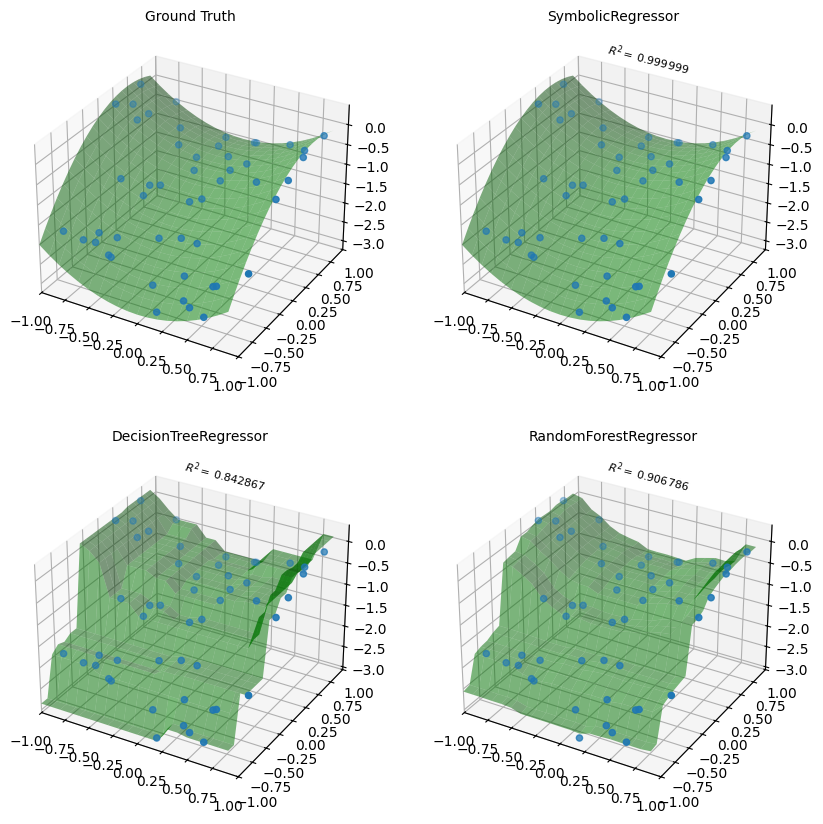

In [34]:
# RUN THIS CELL. Do not change.

y_gp = est_gp.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)
score_gp = est_gp.score(X_test, y_test)
y_tree = est_tree.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)
score_tree = est_tree.score(X_test, y_test)
y_rf = est_rf.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)
score_rf = est_rf.score(X_test, y_test)

fig = plt.figure(figsize=(10, 10))

for i, (y, score, title) in enumerate([(y_truth, None, "Ground Truth"),
                                       (y_gp, score_gp, "SymbolicRegressor"),
                                       (y_tree, score_tree, "DecisionTreeRegressor"),
                                       (y_rf, score_rf, "RandomForestRegressor")]):

    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    surf = ax.plot_surface(x1, x2, y, rstride=1, cstride=1, color='green', alpha=0.5)
    points = ax.scatter(X_train[:, 0], X_train[:, 1], y_train)
    if score is not None:
        score = ax.text(-.7, 1, .2, "$R^2 =\/ %.6f$" % score, 'x', fontsize=8)
    plt.title(title, fontsize = 10)
plt.show()

#### Q3. Which method seems to work best according to the plot? Explain your answer. Is this also what you expected?

SymbolicRegressor of GPLearn works best. Nearly all blue dots are on the green surface. The plot looks similar to the plot of ‘Ground Truth’ and the $R^2$ is the closest to 1 out of all 3 methods.